# Imports

In [54]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=03f28357a57f12f16966f15199d3c6098ee3b82766f565f68c49e161001820fd
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [55]:
import os
import cv2
import joblib
import pickle
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage import exposure
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

from imutils.object_detection import non_max_suppression

import imgaug.augmenters as iaa

# Constant

In [2]:
# Directories containing positive and negative samples
positive_dir = '/kaggle/input/coffee-packets/p'
negative_dir = '/kaggle/input/coffee-packets/n'

# Test video path
video_path = '/kaggle/input/coffee-packets/video1.mp4'

# Util

In [18]:
# Function to extract HoG features from an image
def extract_hog_features(image):
    resized_image = cv2.resize(image, (128, 64))  # Standard size for HoG
    hog_features, hog_image = hog(resized_image, 
                                  orientations=18,
                                  pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), 
                                  visualize=True, 
                                  block_norm='L2-Hys')
    return hog_features, hog_image

def extract_hog_features_over_img(image):
    resized_image = cv2.resize(image, (128, 64))  # Standard size for HoG
    hog_features, hog_image = hog(resized_image, 
                                  orientations=18,
                                  pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), 
                                  visualize=True, 
                                  block_norm='L2-Hys')  # Removed multichannel
    return hog_features

def augment_image(image, num_augmentations=5):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flip
        iaa.Affine(rotate=(-20, 20)),  # rotate
        iaa.Multiply((0.8, 1.2))  # change brightness
    ])
    return [seq(image=image) for _ in range(num_augmentations)]

# Code

In [21]:
# Load and extract HoG features from the dataset
features = []
labels = []

for filename in os.listdir(positive_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image = cv2.imread(os.path.join(positive_dir, filename), cv2.IMREAD_GRAYSCALE)
        hog_feat, _ = extract_hog_features(image)
        features.append(hog_feat)
        labels.append(1)  # Positive samples labeled as 1
        
        # Augment and add the augmented images
        for augmented_image in augment_image(image):
            hog_feat, hog_img = extract_hog_features(image)
            features.append(hog_feat)
            labels.append(1)


for filename in os.listdir(negative_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image = cv2.imread(os.path.join(negative_dir, filename), cv2.IMREAD_GRAYSCALE)
        hog_feat, _ = extract_hog_features(image)
        features.append(hog_feat)
        labels.append(0)  # Negative samples labeled as 0
        
         # Augment and add the augmented images
        for augmented_image in augment_image(image):
            hog_feat, _ = extract_hog_features(image)
            features.append(hog_feat)
            labels.append(0)

In [22]:
# Convert lists to NumPy arrays
features = np.array(features)
labels = np.array(labels)

In [27]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a linear SVM classifier with cross-validation
clf = LinearSVC()
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0


In [28]:
# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       233
           1       1.00      1.00      1.00       127

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360



In [29]:
# Save the model to a file
with open('hog_svm_model.pkl', 'wb') as file:
    joblib.dump(clf, file)

In [30]:
# Load the trained model
model = joblib.load('hog_svm_model.pkl')

In [46]:
# Open the video file
video_capture = cv2.VideoCapture(video_path)

# Check if video file opened successfully
if not video_capture.isOpened():
    raise IOError("Error: Could not open video file.")

# Store video frames in a list
frames = []

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    
    # If the frame was not retrieved properly, break the loop
    if not ret:
        break
    
    # Append frame to the list
    frames.append(frame)

# Release the video capture object
video_capture.release()

In [82]:
# Load the trained SVM model
clf = joblib.load('hog_svm_model.pkl')


# Function to perform detection on a single image
def detect_objects_in_image(image, model, window_size=(80, 80), step_size=20):
    test_img = image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    rects = []
    
    for y in range(0, gray.shape[0] - window_size[1], step_size):
        for x in range(0, gray.shape[1] - window_size[0], step_size):
            window = gray[y:y + window_size[1], x:x + window_size[0]]
            features = extract_hog_features_over_img(window).reshape(1, -1)
            prediction = model.predict(features)

            if prediction == 1:
                rects.append((x, y, x + window_size[0], y + window_size[1]))
    
    # Apply non-maximum suppression to the rectangles
    rects = np.array(rects)
    pick = non_max_suppression(rects, probs=None, overlapThresh=0.1)
    print(len(rects), len(pick))
    
    for (xA, yA, xB, yB) in pick:
        cv2.rectangle(test_img, (xA, yA), (xB, yB), (0, 255, 0), 2)
    
    return test_img

In [85]:
# Run the detection function on a single image
final_image = detect_objects_in_image(frames[14], clf)

21 10


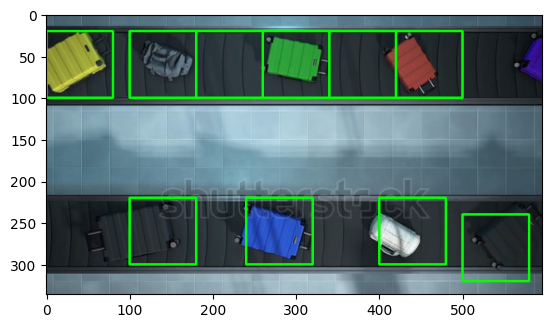

In [86]:
plt.imshow(final_image)
plt.show()